In [2]:
import nltk
from nltk.corpus import brown
from nltk import pos_tag, word_tokenize
from nltk.tag import UnigramTagger, BigramTagger, DefaultTagger
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/himeshhhhhsmac/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/himeshhhhhsmac/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/himeshhhhhsmac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/himeshhhhhsmac/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
brown_tagged_sents = brown.tagged_sents(tagset='universal')
brown_sents = brown.sents()


size = int(len(brown_tagged_sents) * 0.8)
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]

print(f"Training Sentences: {len(train_sents)}")
print(f"Testing Sentences: {len(test_sents)}")

Training Sentences: 45872
Testing Sentences: 11468


In [6]:
default_tagger = DefaultTagger('NOUN')


patterns = [
    (r'.*ing$', 'VERB'),
    (r'.*ed$', 'VERB'),
    (r'.*es$', 'VERB'),
    (r'.*ly$', 'ADV'),
    (r'.*able$', 'ADJ'),
    (r'.*ness$', 'NOUN'),
    (r'.*ment$', 'NOUN'),
    (r'[0-9]+', 'NUM'),
    (r'.*', 'NOUN')
]
regex_tagger = nltk.RegexpTagger(patterns, backoff=default_tagger)


unigram_tagger = UnigramTagger(train_sents, backoff=regex_tagger)


print(unigram_tagger.tag(["This", "is", "a", "simple", "example"]))

[('This', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('simple', 'ADJ'), ('example', 'NOUN')]


In [8]:


bigram_tagger = BigramTagger(train_sents, backoff=unigram_tagger)


rule_based_acc = unigram_tagger.evaluate(test_sents)
statistical_acc = bigram_tagger.evaluate(test_sents)

print(f"Rule-Based Tagger Accuracy: {rule_based_acc:.4f}")
print(f"Statistical (Bigram) Tagger Accuracy: {statistical_acc:.4f}")


/var/folders/g7/n796cwkn2w17m4qhymxv0zr00000gn/T/ipykernel_1166/526438540.py:4: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  rule_based_acc = unigram_tagger.evaluate(test_sents)
/var/folders/g7/n796cwkn2w17m4qhymxv0zr00000gn/T/ipykernel_1166/526438540.py:5: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  statistical_acc = bigram_tagger.evaluate(test_sents)


Rule-Based Tagger Accuracy: 0.9406
Statistical (Bigram) Tagger Accuracy: 0.9494


In [10]:
def flatten_tagged_sents(tagged_sents):
    words, tags = zip(*[(word, tag) for sent in tagged_sents for (word, tag) in sent])
    return words, tags


_, y_true = flatten_tagged_sents(test_sents)


y_pred_rule = [tag for sent in test_sents for (word, tag) in unigram_tagger.tag([w for (w, _) in sent])]
y_pred_stat = [tag for sent in test_sents for (word, tag) in bigram_tagger.tag([w for (w, _) in sent])]


report_rule = precision_recall_fscore_support(y_true, y_pred_rule, average='weighted', zero_division=0)
report_stat = precision_recall_fscore_support(y_true, y_pred_stat, average='weighted', zero_division=0)


metrics_df = pd.DataFrame({
    'Method': ['Rule-Based', 'Statistical (Bigram)'],
    'Precision': [report_rule[0], report_stat[0]],
    'Recall': [report_rule[1], report_stat[1]],
    'F1-Score': [report_rule[2], report_stat[2]],
    'Accuracy': [rule_based_acc, statistical_acc]
})

metrics_df

,Method,Precision,Recall,F1-Score,Accuracy
0,Rule-Based,0.942080,0.940605,0.940672,0.940605
1,Statistical (Bigram),0.949949,0.949412,0.949222,0.949412


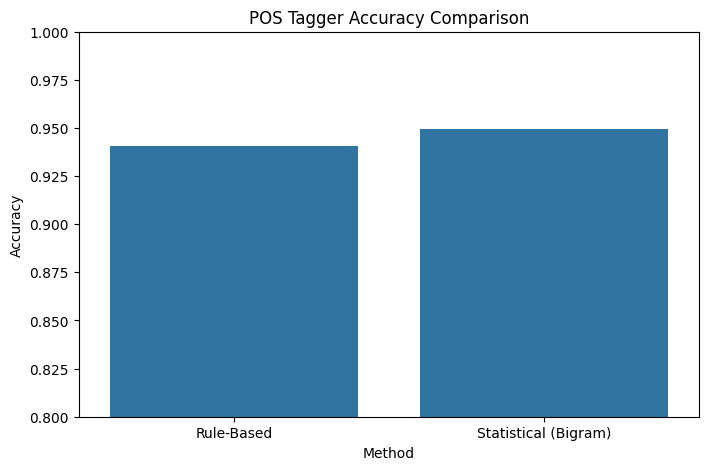

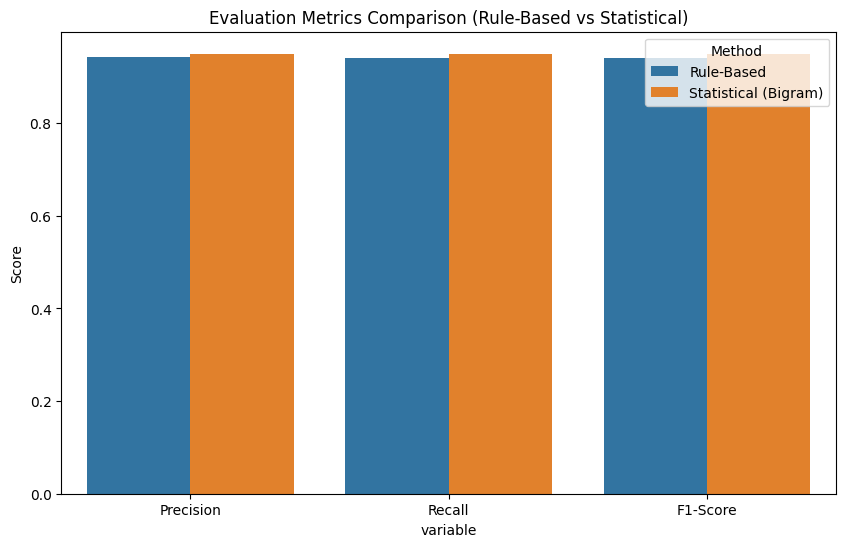

In [12]:
plt.figure(figsize=(8,5))
sns.barplot(x='Method', y='Accuracy', data=metrics_df)
plt.title("POS Tagger Accuracy Comparison")
plt.ylim(0.8, 1.0)
plt.show()

plt.figure(figsize=(10,6))
metrics_melted = metrics_df.melt(id_vars='Method', value_vars=['Precision', 'Recall', 'F1-Score'])
sns.barplot(x='variable', y='value', hue='Method', data=metrics_melted)
plt.title("Evaluation Metrics Comparison (Rule-Based vs Statistical)")
plt.ylabel("Score")
plt.show()

In [14]:
print("Rule-Based Tagger Report:")
print(classification_report(y_true, y_pred_rule, zero_division=0))

print("\nStatistical (Bigram) Tagger Report:")
print(classification_report(y_true, y_pred_stat, zero_division=0))

Rule-Based Tagger Report:
              precision    recall  f1-score   support

           .       1.00      1.00      1.00     29083
         ADJ       0.88      0.86      0.87      9855
         ADP       0.90      0.89      0.90     18434
         ADV       0.92      0.84      0.88     10299
        CONJ       0.99      1.00      0.99      5974
         DET       0.97      0.97      0.97     20030
        NOUN       0.93      0.94      0.93     34030
         NUM       0.87      0.99      0.93      1072
        PRON       1.00      0.94      0.97     13784
         PRT       0.74      0.90      0.81      6513
        VERB       0.96      0.95      0.95     32291
           X       0.64      0.14      0.23       181

    accuracy                           0.94    181546
   macro avg       0.90      0.87      0.87    181546
weighted avg       0.94      0.94      0.94    181546


Statistical (Bigram) Tagger Report:
              precision    recall  f1-score   support

           .   

In [16]:
print("✅ Summary of Findings:")
print(f"Rule-Based Accuracy: {rule_based_acc:.4f}")
print(f"Statistical Accuracy: {statistical_acc:.4f}")
print("Statistical models outperform rule-based ones due to contextual learning.")
print("However, rule-based systems remain useful in low-resource or interpretable settings.")

✅ Summary of Findings:
Rule-Based Accuracy: 0.9406
Statistical Accuracy: 0.9494
Statistical models outperform rule-based ones due to contextual learning.
However, rule-based systems remain useful in low-resource or interpretable settings.
